In [1]:
import os
import kagglehub
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# Import training functions from train.py
from train import train_model, plot_metrics

# Download latest version of the dataset from Kaggle
path = kagglehub.dataset_download("tongpython/cat-and-dog")


### Create train and validation datset with dataloader

In [2]:
# Set subclass of Dataset for kaggle Dataset
class PetDataSet(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes
    
# Set paths to training and test folders with classes as subdirs
train_folder = os.path.join(path, "training_set/training_set")
test_folder = os.path.join(path, "test_set/test_set")

# Get a dictionary associating target values with folder names
target_to_class = {v: k for k, v in ImageFolder(train_folder).class_to_idx.items()}
print("Classes found:", target_to_class)

# Define transformations and create DataLoaders
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


full_dataset = PetDataSet(train_folder, transform=transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

Classes found: {0: 'cats', 1: 'dogs'}


### Train pretrained model

------------------ Starting epoch 1 of 10 ------------------


Testing loop: 100%|██████████| 26/26 [00:06<00:00,  4.05it/s]


New highest accuracy: 0.9544034978138664, saving model...
Train loss: 0.33816981408919566, Test loss: 0.12028208291210306, Accuracy: 0.9544034978138664
------------------ Starting epoch 2 of 10 ------------------


Testing loop: 100%|██████████| 26/26 [00:11<00:00,  2.21it/s]


Train loss: 0.18747952180233396, Test loss: 0.14415063907644715, Accuracy: 0.9381636477201749
------------------ Starting epoch 3 of 10 ------------------


Testing loop: 100%|██████████| 26/26 [00:09<00:00,  2.89it/s]


Train loss: 0.14028454420135253, Test loss: 0.15581950092805946, Accuracy: 0.9312929419113054
------------------ Starting epoch 4 of 10 ------------------


Testing loop: 100%|██████████| 26/26 [00:12<00:00,  2.12it/s]


Train loss: 0.10804481719906146, Test loss: 0.12225733668332836, Accuracy: 0.9494066208619613
------------------ Starting epoch 5 of 10 ------------------


Testing loop: 100%|██████████| 26/26 [00:10<00:00,  2.50it/s]


Train loss: 0.11577158403128553, Test loss: 0.19474090470849512, Accuracy: 0.9175515302935665
------------------ Starting epoch 6 of 10 ------------------


Testing loop: 100%|██████████| 26/26 [00:12<00:00,  2.08it/s]


New highest accuracy: 0.962523422860712, saving model...
Train loss: 0.11929803561747335, Test loss: 0.10237442595937794, Accuracy: 0.962523422860712
------------------ Starting epoch 7 of 10 ------------------


Testing loop: 100%|██████████| 26/26 [00:08<00:00,  3.22it/s]


Train loss: 0.10685781224268366, Test loss: 0.12960525862011665, Accuracy: 0.9412866958151156
------------------ Starting epoch 8 of 10 ------------------


Testing loop: 100%|██████████| 26/26 [00:10<00:00,  2.47it/s]


Train loss: 0.08752284272760619, Test loss: 0.16270276494677416, Accuracy: 0.9400374765771393
------------------ Starting epoch 9 of 10 ------------------


Testing loop: 100%|██████████| 26/26 [00:13<00:00,  1.92it/s]


Train loss: 0.08865355638767372, Test loss: 0.21071904378845419, Accuracy: 0.9262960649594004
------------------ Starting epoch 10 of 10 ------------------


Testing loop: 100%|██████████| 26/26 [00:15<00:00,  1.71it/s]


Train loss: 0.08028666202507118, Test loss: 0.12539845656609738, Accuracy: 0.9525296689569019


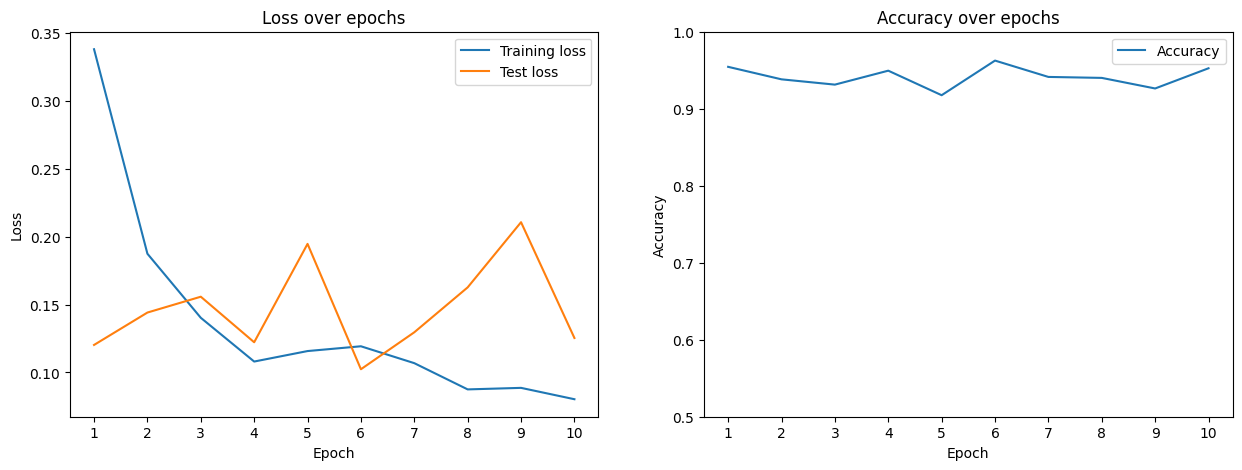

In [3]:
train_losses, test_losses, accuracies = train_model(train_loader, 
                                                    val_loader,
                                                    num_epochs=10, 
                                                    learning_rate=0.001, 
                                                    model_name="pretrained_classifier",
                                                    pretrained=True,
                                                    use_LR_scheduler=True)
plot_metrics(train_losses, test_losses, accuracies)

## Train model from scratch

------------------ Starting epoch 1 of 25 ------------------


Testing loop: 100%|██████████| 26/26 [00:05<00:00,  4.58it/s]


New highest accuracy: 0.5827607745159276, saving model...
Train loss: 0.6758166282047412, Test loss: 0.6727122355445633, Accuracy: 0.5827607745159276
------------------ Starting epoch 2 of 25 ------------------


Testing loop: 100%|██████████| 26/26 [00:05<00:00,  4.35it/s]


Train loss: 0.6556519086773436, Test loss: 0.793949882065334, Accuracy: 0.5071830106183636
------------------ Starting epoch 3 of 25 ------------------


Testing loop: 100%|██████████| 26/26 [00:06<00:00,  4.21it/s]


New highest accuracy: 0.6377264209868831, saving model...
Train loss: 0.6365205227844719, Test loss: 0.6848501609236951, Accuracy: 0.6377264209868831
------------------ Starting epoch 4 of 25 ------------------


Testing loop: 100%|██████████| 26/26 [00:05<00:00,  4.36it/s]


Train loss: 0.6316985309235682, Test loss: 0.6725277776348821, Accuracy: 0.5915053091817614
------------------ Starting epoch 5 of 25 ------------------


Testing loop: 100%|██████████| 26/26 [00:05<00:00,  4.38it/s]


New highest accuracy: 0.6895690193628982, saving model...
Train loss: 0.603392659128643, Test loss: 0.6010354521831522, Accuracy: 0.6895690193628982
------------------ Starting epoch 6 of 25 ------------------


Testing loop: 100%|██████████| 26/26 [00:05<00:00,  4.45it/s]


Train loss: 0.5999692270414745, Test loss: 0.6247822413177955, Accuracy: 0.6695815115552779
------------------ Starting epoch 7 of 25 ------------------


Testing loop: 100%|██████████| 26/26 [00:05<00:00,  4.43it/s]


Train loss: 0.5775534254658751, Test loss: 0.5958889023558488, Accuracy: 0.6764522173641474
------------------ Starting epoch 8 of 25 ------------------


Testing loop: 100%|██████████| 26/26 [00:05<00:00,  4.44it/s]


Train loss: 0.5548043378362948, Test loss: 0.7146827265815687, Accuracy: 0.5621486570893192
------------------ Starting epoch 9 of 25 ------------------


Testing loop: 100%|██████████| 26/26 [00:05<00:00,  4.39it/s]


Train loss: 0.5571102968869099, Test loss: 0.6157327777218029, Accuracy: 0.6720799500312304
------------------ Starting epoch 10 of 25 ------------------


Testing loop: 100%|██████████| 26/26 [00:05<00:00,  4.43it/s]


New highest accuracy: 0.7039350405996252, saving model...
Train loss: 0.5426847365854086, Test loss: 0.6272584612223597, Accuracy: 0.7039350405996252
------------------ Starting epoch 11 of 25 ------------------


Testing loop: 100%|██████████| 26/26 [00:05<00:00,  4.36it/s]


Train loss: 0.5357585010641742, Test loss: 0.6148805546339864, Accuracy: 0.6870705808869456
------------------ Starting epoch 12 of 25 ------------------


Testing loop: 100%|██████████| 26/26 [00:05<00:00,  4.44it/s]


Train loss: 0.5214165156238307, Test loss: 0.6103711769096484, Accuracy: 0.6920674578388507
------------------ Starting epoch 13 of 25 ------------------


Testing loop: 100%|██████████| 26/26 [00:05<00:00,  4.46it/s]


New highest accuracy: 0.7364147407870081, saving model...
Train loss: 0.49902956009953564, Test loss: 0.5371239010342336, Accuracy: 0.7364147407870081
------------------ Starting epoch 14 of 25 ------------------


Testing loop: 100%|██████████| 26/26 [00:05<00:00,  4.37it/s]


New highest accuracy: 0.7470331043098064, saving model...
Train loss: 0.5159328009172353, Test loss: 0.5182668620965989, Accuracy: 0.7470331043098064
------------------ Starting epoch 15 of 25 ------------------


Testing loop: 100%|██████████| 26/26 [00:05<00:00,  4.40it/s]


Train loss: 0.5092416670566645, Test loss: 0.5575243132392516, Accuracy: 0.7189256714553404
------------------ Starting epoch 16 of 25 ------------------


Testing loop: 100%|██████████| 26/26 [00:05<00:00,  4.39it/s]


Train loss: 0.5059782064459906, Test loss: 0.6354449292334223, Accuracy: 0.6470955652717052
------------------ Starting epoch 17 of 25 ------------------


Testing loop: 100%|██████████| 26/26 [00:05<00:00,  4.43it/s]


Train loss: 0.47814046673890875, Test loss: 0.5302643140802378, Accuracy: 0.7445346658338539
------------------ Starting epoch 18 of 25 ------------------


Testing loop: 100%|██████████| 26/26 [00:05<00:00,  4.38it/s]


Train loss: 0.4696348221282673, Test loss: 0.5191273300871858, Accuracy: 0.7395377888819488
------------------ Starting epoch 19 of 25 ------------------


Testing loop: 100%|██████████| 26/26 [00:05<00:00,  4.40it/s]


New highest accuracy: 0.7632729544034978, saving model...
Train loss: 0.4669699704624726, Test loss: 0.5060997483047711, Accuracy: 0.7632729544034978
------------------ Starting epoch 20 of 25 ------------------


Testing loop: 100%|██████████| 26/26 [00:05<00:00,  4.41it/s]


New highest accuracy: 0.7682698313554028, saving model...
Train loss: 0.43091350421542157, Test loss: 0.4962334772461396, Accuracy: 0.7682698313554028
------------------ Starting epoch 21 of 25 ------------------


Testing loop: 100%|██████████| 26/26 [00:05<00:00,  4.41it/s]


Train loss: 0.419128323349634, Test loss: 0.4725563824502548, Accuracy: 0.7663960024984384
------------------ Starting epoch 22 of 25 ------------------


Testing loop: 100%|██████████| 26/26 [00:05<00:00,  4.37it/s]


New highest accuracy: 0.7695190505933791, saving model...
Train loss: 0.4457460420716933, Test loss: 0.4901134242942972, Accuracy: 0.7695190505933791
------------------ Starting epoch 23 of 25 ------------------


Testing loop: 100%|██████████| 26/26 [00:05<00:00,  4.43it/s]


Train loss: 0.42869339817244884, Test loss: 0.559315425103564, Accuracy: 0.7445346658338539
------------------ Starting epoch 24 of 25 ------------------


Testing loop: 100%|██████████| 26/26 [00:05<00:00,  4.37it/s]


New highest accuracy: 0.7732667083073079, saving model...
Train loss: 0.3928802653002337, Test loss: 0.46858010719065496, Accuracy: 0.7732667083073079
------------------ Starting epoch 25 of 25 ------------------


Testing loop: 100%|██████████| 26/26 [00:05<00:00,  4.43it/s]


Train loss: 0.37654574765479987, Test loss: 0.5415935634445169, Accuracy: 0.7620237351655216


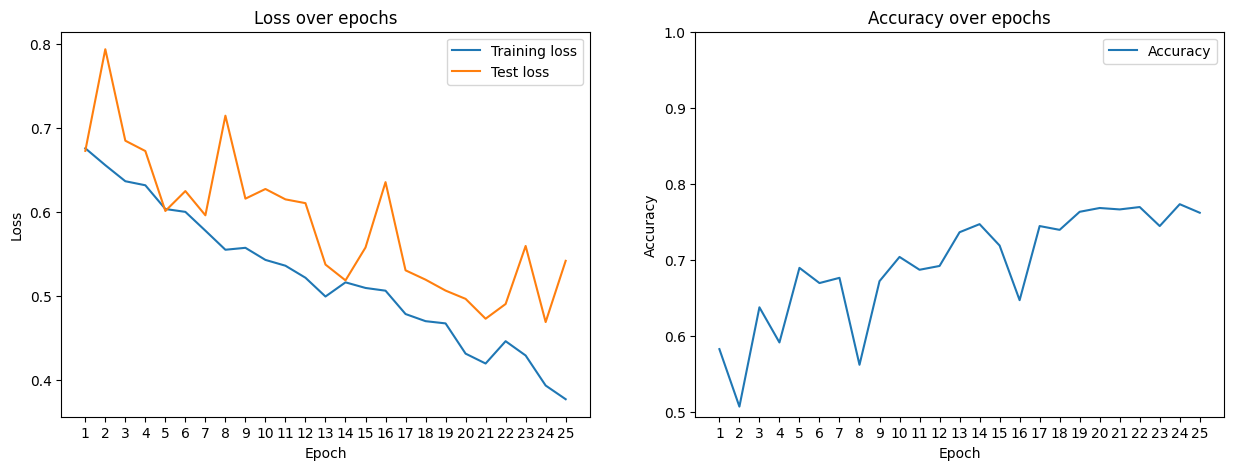

In [6]:
train_losses, test_losses, accuracies = train_model(train_loader, 
                                                    val_loader, 
                                                    num_epochs=25, 
                                                    learning_rate=0.001, 
                                                    model_name="scratch_classifier", 
                                                    pretrained=False,
                                                    use_LR_scheduler=True)
plot_metrics(train_losses, test_losses, accuracies)